In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import make_classification
import sys
sys.path.append('../')
%matplotlib inline
pd.options.display.max_columns = 25

<img src="img/alura-vox.png" style="height:260px">

# Tarefas da Semana 3

- [ ] Verificar se a variável target está balanceada (undersampling ou oversampling)
- [ ] Aplicar encoding nos seus dados
- [ ] Criar dois ou mais modelos de Machine Learning
- [ ] Avaliar cada modelo utilizando métricas de ML
- [ ] Escolher o melhor modelo (justificar a escolha)
- [ ] Otimizar o melhor modelo
- [ ] Verificar qual o melhor tipo de balanceamento com esses dados

# Carregando Base de Dados
### Os dados usados já foram tratados e organizados na semana anterior

In [82]:
dados = pd.read_json('../Dados/dados_churn_clean.json')
dados.head()

,cliente_id,churn,genero,idoso,casado,dependentes,duracao_contrato,assinatura_telefone,linhas_extras,assinatura_internet,protecao_online,backup_nuvem,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,contrato,cobranca_digital,metodo_pagamento,custo_diario,custo_mensal,custo_total
0,0002-ORFBO,Não,Feminino,Não,Sim,Sim,9,Sim,Não,dsl,Não,Sim,Não,Sim,Sim,Não,Anual,Sim,Cheque,2.19,65.6,593.30
1,0003-MKNFE,Não,Masculino,Não,Não,Não,9,Sim,Sim,dsl,Não,Não,Não,Não,Não,Sim,Mensal,Não,Cheque,2.00,59.9,542.40
2,0004-TLHLJ,Sim,Masculino,Não,Não,Não,4,Sim,Não,fibra,Não,Não,Sim,Não,Não,Não,Mensal,Sim,Cheque eletrônico,2.46,73.9,280.85
3,0011-IGKFF,Sim,Masculino,Sim,Sim,Não,13,Sim,Não,fibra,Não,Sim,Sim,Não,Sim,Sim,Mensal,Sim,Cheque eletrônico,3.27,98.0,1237.85
4,0013-EXCHZ,Sim,Feminino,Sim,Sim,Não,3,Sim,Não,fibra,Não,Não,Não,Sim,Sim,Não,Mensal,Sim,Cheque,2.80,83.9,267.40


# Ocorrências de Churn
Esses valores serão analisados posteriormente para verificar a possibilidade de tratamento de under ou oversampling.

In [85]:
churn = dados.churn.value_counts().to_frame().T
churn['Proporção'] = round(churn['Não'] / churn['Sim'],2)
churn

,Não,Sim,Proporção
churn,5174,1869,2.77


Podemos ver que temos uma proporção de 2.77 : 1 na variável target `churn`.

# Verificando as variáveis categóricas que serão tratadas

In [86]:
for coluna in dados.columns[1:]:
    if dados[coluna].dtype == 'object':
        print(f'Variável {coluna}:', dados[coluna].unique())

Variável churn: ['Não' 'Sim']
Variável genero: ['Feminino' 'Masculino']
Variável idoso: ['Não' 'Sim']
Variável casado: ['Sim' 'Não']
Variável dependentes: ['Sim' 'Não']
Variável assinatura_telefone: ['Sim' 'Não']
Variável linhas_extras: ['Não' 'Sim' 'Sem assinatura de telefone']
Variável assinatura_internet: ['dsl' 'fibra' 'não contratada']
Variável protecao_online: ['Não' 'Sim' 'internet não contratada']
Variável backup_nuvem: ['Sim' 'Não' 'internet não contratada']
Variável protecao_dispositivo: ['Não' 'Sim' 'internet não contratada']
Variável suporte_tecnico: ['Sim' 'Não' 'internet não contratada']
Variável streaming_tv: ['Sim' 'Não' 'internet não contratada']
Variável streaming_filmes: ['Não' 'Sim' 'internet não contratada']
Variável contrato: ['Anual' 'Mensal' 'Bianual']
Variável cobranca_digital: ['Sim' 'Não']
Variável metodo_pagamento: ['Cheque' 'Cheque eletrônico' 'Cartão de crédito' 'Transferência bancária']


# Explicando o processo de ajuste:
Vamos realizar algumas alterações dentro da base de dados para que seja possível rodar os testes e criar o modelo de machine learning.

## As variáveis que serão tratadas neste momento:
Para isso vamos alterar os valores `Sim` e `Não` para `1` e `0` respectivamente, para as variáveis categóricas destacadas:
* `churn`
* `genero`
* `idoso`
* `casado` neste caso serão convertidos da seguinte maneira: Masculino será 0 e Feminino será definido como 1
* `dependentes`
* `assinatura_telefone`
* `cobrança_digital`

Já as demais variáveis categóricas serão tratadas utilizando o `método dummies` da biblioteca Pandas.


In [87]:
ajuste_binario = {'Não': 0, 'Sim': 1, 'Masculino': 0, 'Feminino': 1}
selecao = ['churn', 'genero', 'idoso', 'casado', 'dependentes', 'assinatura_telefone', 'cobranca_digital']

for coluna in dados.columns:
    if coluna in selecao:
        dados[coluna].replace(ajuste_binario, inplace = True)
dados.drop(columns = 'cliente_id', inplace = True)        
dados.head()

,churn,genero,idoso,casado,dependentes,duracao_contrato,assinatura_telefone,linhas_extras,assinatura_internet,protecao_online,backup_nuvem,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,contrato,cobranca_digital,metodo_pagamento,custo_diario,custo_mensal,custo_total
0,0,1,0,1,1,9,1,Não,dsl,Não,Sim,Não,Sim,Sim,Não,Anual,1,Cheque,2.19,65.6,593.30
1,0,0,0,0,0,9,1,Sim,dsl,Não,Não,Não,Não,Não,Sim,Mensal,0,Cheque,2.00,59.9,542.40
2,1,0,0,0,0,4,1,Não,fibra,Não,Não,Sim,Não,Não,Não,Mensal,1,Cheque eletrônico,2.46,73.9,280.85
3,1,0,1,1,0,13,1,Não,fibra,Não,Sim,Sim,Não,Sim,Sim,Mensal,1,Cheque eletrônico,3.27,98.0,1237.85
4,1,1,1,1,0,3,1,Não,fibra,Não,Não,Não,Sim,Sim,Não,Mensal,1,Cheque,2.80,83.9,267.40


In [88]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   churn                 7043 non-null   int64  
 1   genero                7043 non-null   int64  
 2   idoso                 7043 non-null   int64  
 3   casado                7043 non-null   int64  
 4   dependentes           7043 non-null   int64  
 5   duracao_contrato      7043 non-null   int64  
 6   assinatura_telefone   7043 non-null   int64  
 7   linhas_extras         7043 non-null   object 
 8   assinatura_internet   7043 non-null   object 
 9   protecao_online       7043 non-null   object 
 10  backup_nuvem          7043 non-null   object 
 11  protecao_dispositivo  7043 non-null   object 
 12  suporte_tecnico       7043 non-null   object 
 13  streaming_tv          7043 non-null   object 
 14  streaming_filmes      7043 non-null   object 
 15  contrato             

In [89]:
variaveis_dummy = []
for coluna in dados.columns[1:]:
    if dados[coluna].dtype == 'object':
        print(f'Variável {coluna}:', dados[coluna].unique())
        variaveis_dummy.append(coluna)

Variável linhas_extras: ['Não' 'Sim' 'Sem assinatura de telefone']
Variável assinatura_internet: ['dsl' 'fibra' 'não contratada']
Variável protecao_online: ['Não' 'Sim' 'internet não contratada']
Variável backup_nuvem: ['Sim' 'Não' 'internet não contratada']
Variável protecao_dispositivo: ['Não' 'Sim' 'internet não contratada']
Variável suporte_tecnico: ['Sim' 'Não' 'internet não contratada']
Variável streaming_tv: ['Sim' 'Não' 'internet não contratada']
Variável streaming_filmes: ['Não' 'Sim' 'internet não contratada']
Variável contrato: ['Anual' 'Mensal' 'Bianual']
Variável metodo_pagamento: ['Cheque' 'Cheque eletrônico' 'Cartão de crédito' 'Transferência bancária']


In [90]:
dados = pd.get_dummies(data = dados, columns = variaveis_dummy)
dados.head()

,churn,genero,idoso,casado,dependentes,duracao_contrato,assinatura_telefone,cobranca_digital,custo_diario,custo_mensal,custo_total,linhas_extras_Não,...,streaming_tv_Sim,streaming_tv_internet não contratada,streaming_filmes_Não,streaming_filmes_Sim,streaming_filmes_internet não contratada,contrato_Anual,contrato_Bianual,contrato_Mensal,metodo_pagamento_Cartão de crédito,metodo_pagamento_Cheque,metodo_pagamento_Cheque eletrônico,metodo_pagamento_Transferência bancária
0,0,1,0,1,1,9,1,1,2.19,65.6,593.30,1,...,1,0,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,9,1,0,2.00,59.9,542.40,0,...,0,0,0,1,0,0,0,1,0,1,0,0
2,1,0,0,0,0,4,1,1,2.46,73.9,280.85,1,...,0,0,1,0,0,0,0,1,0,0,1,0
3,1,0,1,1,0,13,1,1,3.27,98.0,1237.85,1,...,1,0,0,1,0,0,0,1,0,0,1,0
4,1,1,1,1,0,3,1,1,2.80,83.9,267.40,1,...,1,0,1,0,0,0,0,1,0,1,0,0


# Gerando Perfil da Base de Dados
### O perfil dos dados será salvo num documento externo no formato HTML, permitindo sua posterior consulta

In [53]:
perfil_dadosv2 = pandas_profiling.ProfileReport(dados)
perfil_dadosv2.to_file('perfil_aluravozv2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Regressão Logística
Vamos treinar o modelo

In [91]:
x = dados.drop(columns = 'churn')
y = dados.churn

In [92]:
SEED = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = SEED)

In [93]:
lr = LogisticRegression(max_iter = 1000, random_state = SEED)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print('Acurácia:', metrics.accuracy_score(y_test, y_pred))
print('Precisão:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score', metrics.f1_score(y_test, y_pred))

Acurácia: 0.8165814877910278
Precisão: 0.6866485013623979
Recall: 0.5478260869565217
F1 Score 0.6094316807738815


## A variável target está balanceada?
Não, já tinha sido conferido sua proporção inicialmente, mas através dos resultados obtidos na célula acima, podemos ver seu impacto no modelo. Com isso iremos balancear sua proporção para obtermos melhores resultados no modelo.

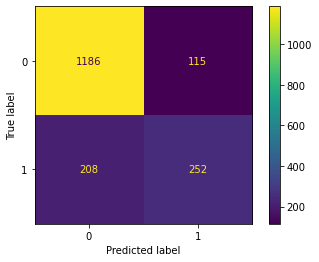

In [94]:
cm = confusion_matrix(y_test, y_pred)
matriz_confusao = ConfusionMatrixDisplay(confusion_matrix = cm)
matriz_confusao.plot()

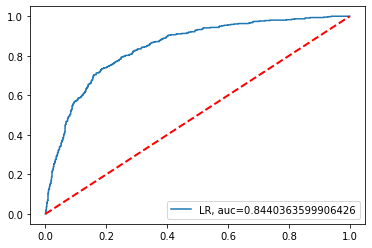

In [95]:
y_pred_proba = lr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc='+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4)